<a href="https://colab.research.google.com/github/smf-9000/Text-Intent-Classification/blob/main/Text_Classification_LSTM_glove_snips_imdb%5Bsentiment_classification_example%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMDb dataset

In [1]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2021-07-11 14:46:53--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  27.5MB/s    in 2.9s    

2021-07-11 14:46:56 (27.5 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [2]:
from pathlib import Path
import pandas as pd

vocab_size = 10000
max_length = 500
no_of_classes = 2

sentences = []
labels = []

def read_imdb_split(split_dir):
    split_dir = Path(split_dir)
    texts = []
    labels = []
    for label_dir in ["pos", "neg"]:
        for text_file in (split_dir/label_dir).iterdir():
            texts.append(text_file.read_text())
            labels.append(0 if label_dir is "neg" else 1)

    return texts, labels

train_texts, train_labels = read_imdb_split('aclImdb/train')
test_texts, test_labels = read_imdb_split('aclImdb/test')

sentences = train_texts + test_texts
labels = train_labels + test_labels

In [3]:
no_of_classes

2

In [ ]:
list(zip(sentences, labels))

## snips dataset

In [ ]:
!wget https://raw.githubusercontent.com/vgtomahawk/LR_GC_OOD/master/code/data/snips/train.csv

In [ ]:
import pandas as pd
from sklearn import preprocessing

vocab_size = 10000
max_length = 100

data = pd.read_csv('/content/train.csv')

le = preprocessing.LabelEncoder()
le.fit(data.label)
data['lbl'] = le.transform(data.label)
no_of_classes = data['lbl'].nunique()
# print(no_of_classes)
data.head()

In [ ]:
sentences = []
labels = []
for _, row in data.iterrows():
  sentences.append(row['text'])
  labels.append(row['lbl'])

In [ ]:
list(zip(sentences, labels))



```
# ----------------------------------------------------------------------
```



## code

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import text, sequence

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

# vocab_size = 10000
# max_length = 100

X_train, X_test, Y_train, Y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

tokenizer = text.Tokenizer(vocab_size)
tokenizer.fit_on_texts(np.concatenate([X_train, X_test]))

train_tokenized = tokenizer.texts_to_sequences(X_train) 
train_inputs = sequence.pad_sequences(train_tokenized, maxlen=max_length)

test_tokenized = tokenizer.texts_to_sequences(X_test) 
test_inputs = sequence.pad_sequences(test_tokenized, maxlen=max_length)

training_labels_final = np.array(Y_train)
testing_labels_final = np.array(Y_test)

## Glove

In [7]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-07-11 14:49:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-11 14:49:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-11 14:49:06--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [8]:
glove_dim = 200
glove_file = '/content/glove.6B.' + str(glove_dim) + 'd.txt'
emb_dict = {}
glove = open(glove_file)
for line in glove:
  values = line.split()
  word = values[0]
  vector = np.asarray(values[1:], dtype='float32')
  emb_dict[word] = vector
glove.close()

In [9]:
emb_matrix = np.zeros((vocab_size, glove_dim))
for w, i in tokenizer.word_index.items():
  if i < vocab_size:
    vect = emb_dict.get(w)
    if vect is not None:
      emb_matrix[i] = vect
  else:
    break



```
# ----------------------------------------------------------------------
```



## code

In [10]:
_loss="binary_crossentropy"
_optimizer="adam"
_metrics=["accuracy"]
if no_of_classes != 2:
  _loss="sparse_categorical_crossentropy"
  _optimizer="adam"
  _metrics=["sparse_categorical_accuracy"]

In [11]:
num_epochs = 10

class DCLIN(tf.keras.Model):
    
    def __init__(self):
        super(DCLIN, self).__init__(name='model_i')
        
        # self.embedding = layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
        self.embedding = layers.Embedding(
                            vocab_size,
                            glove_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(emb_matrix),
                            trainable=False)
        self.pool_1 = layers.GlobalAveragePooling1D()
        self.dense_1 = layers.Dense(
                            units=256,
                            activation="relu")
        self.dense_last = layers.Dense(
                            units=no_of_classes if no_of_classes != 2 else 1,
                            activation="sigmoid")
        self.dropout_d = layers.Dropout(rate=0.2)

    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x = self.pool_1(x)
        x = self.dense_1(x)
        x = self.dropout_d(x)
        output = self.dense_last(x)
        return output

model = DCLIN()
model.compile(loss=_loss, optimizer=_optimizer, metrics=_metrics)
history = model.fit(
                  train_inputs,
                  training_labels_final,
                  epochs=num_epochs,
                  shuffle=True,
                  validation_data=(test_inputs, testing_labels_final))

Epoch 1/10
1250/1250 [==============================] - 13s 7ms/step - loss: 0.5393 - accuracy: 0.7451 - val_loss: 0.4639 - val_accuracy: 0.7940
Epoch 2/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.4490 - accuracy: 0.7998 - val_loss: 0.4230 - val_accuracy: 0.8090
Epoch 3/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.4235 - accuracy: 0.8078 - val_loss: 0.4465 - val_accuracy: 0.7892
Epoch 4/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.4129 - accuracy: 0.8129 - val_loss: 0.4042 - val_accuracy: 0.8171
Epoch 5/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.4071 - accuracy: 0.8164 - val_loss: 0.4300 - val_accuracy: 0.8016
Epoch 6/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.4021 - accuracy: 0.8181 - val_loss: 0.3941 - val_accuracy: 0.8193
Epoch 7/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.4001 - accuracy: 0.8188 - val_loss: 0.3930 - val_accuracy

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

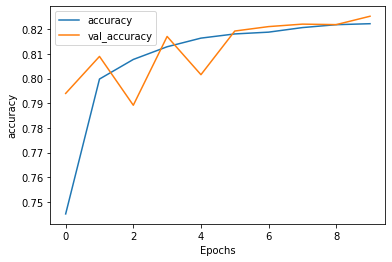

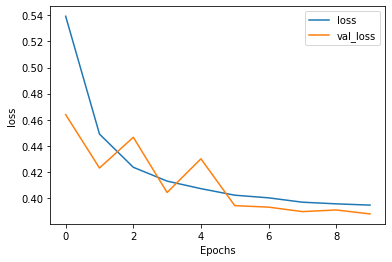

In [13]:
plot_graphs(history, _metrics[0])
plot_graphs(history, "loss")



```
# ----------------------------------------------------------------------
```



In [28]:
num_epochs = 10

class DCLSTM(tf.keras.Model):
    
    def __init__(self):
        super(DCLSTM, self).__init__(name='model_ii')
        
        # self.embedding = layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
        self.embedding = layers.Embedding(
                            vocab_size,
                            glove_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(emb_matrix),
                            trainable=False)
        # self.pool_1 = layers.GlobalAveragePooling1D()
        self.lstm_1 = layers.Bidirectional(layers.LSTM(256))
        self.dense_1 = layers.Dense(
                            units=256,
                            activation="relu")
        self.dense_last = layers.Dense(
                            units=no_of_classes if no_of_classes != 2 else 1,
                            activation="sigmoid")
        self.dropout_e = layers.Dropout(rate=0.2)
        self.dropout_d = layers.Dropout(rate=0.2)

    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x = self.dropout_e(x)
        # x = self.pool_1(x)
        x = self.lstm_1(x)
        x = self.dense_1(x)
        x = self.dropout_d(x)
        output = self.dense_last(x)
        return output

model = DCLSTM()
model.compile(loss=_loss, optimizer=_optimizer, metrics=_metrics)
history = model.fit(
                  train_inputs,
                  training_labels_final,
                  batch_size=256,
                  epochs=num_epochs,
                  shuffle=True,
                  validation_data=(test_inputs, testing_labels_final))

Epoch 1/10
157/157 [==============================] - 54s 328ms/step - loss: 0.5484 - accuracy: 0.7217 - val_loss: 0.4529 - val_accuracy: 0.8009
Epoch 2/10
157/157 [==============================] - 50s 321ms/step - loss: 0.4062 - accuracy: 0.8210 - val_loss: 0.3544 - val_accuracy: 0.8558
Epoch 3/10
157/157 [==============================] - 51s 323ms/step - loss: 0.3331 - accuracy: 0.8576 - val_loss: 0.2936 - val_accuracy: 0.8786
Epoch 4/10
157/157 [==============================] - 51s 323ms/step - loss: 0.2919 - accuracy: 0.8781 - val_loss: 0.3295 - val_accuracy: 0.8640
Epoch 5/10
157/157 [==============================] - 51s 324ms/step - loss: 0.2584 - accuracy: 0.8924 - val_loss: 0.2625 - val_accuracy: 0.8962
Epoch 6/10
157/157 [==============================] - 51s 325ms/step - loss: 0.2422 - accuracy: 0.8995 - val_loss: 0.2900 - val_accuracy: 0.8770
Epoch 7/10
157/157 [==============================] - 51s 325ms/step - loss: 0.2230 - accuracy: 0.9093 - val_loss: 0.2868 - val_ac

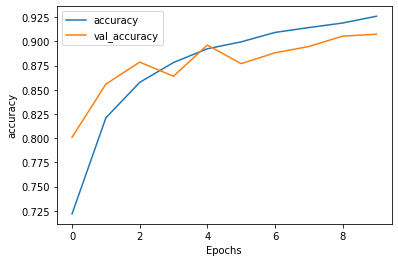

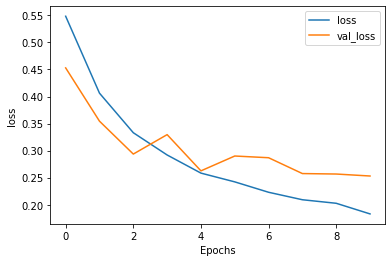

In [30]:
plot_graphs(history, _metrics[0])
plot_graphs(history, "loss")



```
# ----------------------------------------------------------------------
```



In [31]:
num_epochs = 10

class DCLSTM(tf.keras.Model):
    
    def __init__(self):
        super(DCLSTM, self).__init__(name='model_iii')
        
        # self.embedding = layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
        self.embedding = layers.Embedding(
                            vocab_size,
                            glove_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(emb_matrix),
                            trainable=False)
        # self.pool_1 = layers.GlobalAveragePooling1D()
        self.lstm_1 = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2))
        self.lstm_2 = layers.Bidirectional(layers.LSTM(256, dropout=0.2))
        self.rv_1 = layers.RepeatVector(3)
        self.dense_1 = layers.Dense(
                            units=256,
                            activation="relu")
        self.dense_last = layers.Dense(
                            units=no_of_classes if no_of_classes != 2 else 1,
                            activation="sigmoid")
        self.dropout_e = layers.Dropout(rate=0.2)
        self.dropout_d = layers.Dropout(rate=0.2)

    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x = self.dropout_e(x)
        # x = self.pool_1(x)
        x = self.lstm_1(x)
        x = self.lstm_2(x)
        x = self.dense_1(x)
        x = self.dropout_d(x)
        output = self.dense_last(x)
        return output

model = DCLSTM()
model.compile(loss=_loss, optimizer=_optimizer, metrics=_metrics)
history = model.fit(
                  train_inputs,
                  training_labels_final,
                  batch_size=256,
                  epochs=num_epochs,
                  shuffle=True,
                  validation_data=(test_inputs, testing_labels_final))

Epoch 1/10
157/157 [==============================] - 138s 842ms/step - loss: 0.5449 - accuracy: 0.7228 - val_loss: 0.4482 - val_accuracy: 0.8017
Epoch 2/10
157/157 [==============================] - 130s 828ms/step - loss: 0.4436 - accuracy: 0.7970 - val_loss: 0.3740 - val_accuracy: 0.8378
Epoch 3/10
157/157 [==============================] - 130s 828ms/step - loss: 0.4111 - accuracy: 0.8168 - val_loss: 0.3537 - val_accuracy: 0.8484
Epoch 4/10
157/157 [==============================] - 130s 830ms/step - loss: 0.3565 - accuracy: 0.8438 - val_loss: 0.3081 - val_accuracy: 0.8725
Epoch 5/10
157/157 [==============================] - 130s 829ms/step - loss: 0.3016 - accuracy: 0.8728 - val_loss: 0.3493 - val_accuracy: 0.8669
Epoch 6/10
157/157 [==============================] - 130s 828ms/step - loss: 0.2793 - accuracy: 0.8830 - val_loss: 0.2616 - val_accuracy: 0.8911
Epoch 7/10
157/157 [==============================] - 130s 829ms/step - loss: 0.2629 - accuracy: 0.8902 - val_loss: 0.2817 -

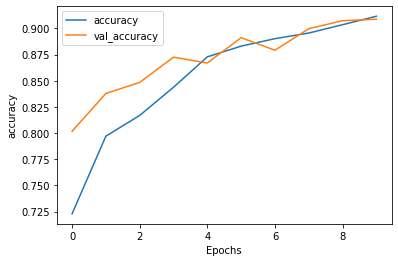

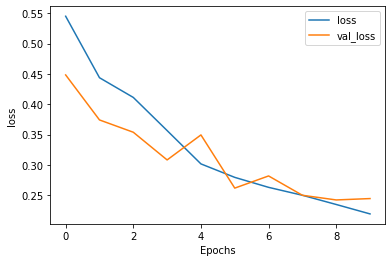

In [32]:
plot_graphs(history, _metrics[0])
plot_graphs(history, "loss")



```
# ----------------------------------------------------------------------
```



In [33]:
def predict_review(model, new_sentences, maxlen=max_length):
  new_sequences = tokenizer.texts_to_sequences(new_sentences) 
  new_sequences_padded = sequence.pad_sequences(new_sequences, maxlen=max_length)

  classes = model.predict(new_sequences_padded)

  C = []
  for x in range(len(new_sentences)):
    C.append(classes[x][0])
  return C

In [34]:
P = predict_review(model, X_test, maxlen=max_length)

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

P = [1 if x > 0.5 else 0 for x in P]
class_names = ['negative', 'positive']
print(classification_report(testing_labels_final, P, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.90      0.92      0.91      4945
    positive       0.92      0.90      0.91      5055

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [35]:
Test_i = ["Arrival was one of my most anticipated movies of 2016 I loved all the trailers for this film and the talent behind it made me even more excited to see the final product and I can safely say that I was blown away by the final product. This is a slow burning, thought provoking and incredibly intriguing Sci Fi masterpiece that I think in future years will become a classic. Amy Adams gives one of the greatest performances of her entire career in this film, she perfect embodies someone who is determined in her pursuit but damaged by her experiences and it's a performance that will hopefully give her an Oscar. Jeremy Renner was just perfect casting for this film he was incredibly convincing in this film and his chemistry with Adams was fantastic. Forrest Whitaker was great in this film and it was nice to see a different type of role from him. The slow pacing of this film worked perfectly it helped to build up the slow burning suspense and gave the characters more time to be developed better. The special effects in this film are also fantastic mainly because they are used sparingly as it is clear that the focus is more on the characters. Denis Villeneuve did such an amazing job directing this film he really sucked you into the situation and made it seem more life like. This film asks a lot of questions about humanity and how it interacts and these questions are incredibly intriguing and thought provoking it forces the audience to think on real life and accurate the events of this film are to real life. The whole mystery of why the aliens are here is done perfectly you're more that likely to change your mind at least once and when a mystery like that is built up for so long it's hard to make the eventual discovery satisfying but in this case it was, the eventual reveal makes you look at this film in an entirely different way, the film also doesn't feel the need to answer every question it asks leaving certain things ambiguous that allows the viewer to think on their own answers.",
"This looked like an action thriller but turned up to be a crap. Aliens arrive and look like giant blobs of something but you never know because there is a convenient glass screen to blow smoke signals and make blubber whale sounds our something awful. The sounds in the theatre actually caused discomfort. Later I watched another movie with an eerie similar sound, Blade Runner, and guess what? Same sorry director and also a dud movie. Some critic described this as a cerebral experience. Nerds. It's not even close to that either. I'm mad I can't get back that time or money wasted on this trash. It's simply put about language communication and some hidden liberal agenda bs and creating world damage.",
"Actually I consider myself very lucky to watch this movie....wait... AND to find the escape gate quick enough within the first 30 minutes. Phewww....!! What a load of rubbish and horseshit! I am so relieved and feel so lucky that I avoided suffering a hellish ordeal for 2 hours as others had to. Utter waste of money and time! I am so amazed Amy Adams even agreed to act here? Didn't she have anything else to do? I am even more amazed at the 'best' IMDb reviews here claiming this crap as a 'classic' masterpiece! To me it was a classic death by boredom!Avoid at any cost!! All those who voted over 1/10 must get their heads examined!",
"Denis Villenueve has done it again. Arrival is nothing short of a brilliant film. The performance of Amy Adams is absolutely spectacular, as she captures the determination, smartness, uncertainty, and emotion of the character brilliantly (how did she not win, let alone get nominated for best actress-the Oscars are such a leftist propaganda show and a joke), and Jeremy Renner is terrific as always in his role, perfectly portraying the intelligence of his character while still minding the situation of those around him. Forrest Whitaker also turns in a solid supporting performance, and the direction of Villenueve is beyond incredible. A phenomenal film, and the best of 2016."]
Label_i = [1,0,0,1]

In [36]:
P = predict_review(model, Test_i, maxlen=max_length)
print(P)
print(Label_i)

[0.9803239, 0.0018621242, 0.0023195227, 0.9986047]
[1, 0, 0, 1]
